In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import pandas as pd
from net_model import *
from scipy.spatial.distance import cdist
from matplotlib import gridspec
import pickle
import os
import scipy.ndimage as scim
from image_dataset import *

In [2]:
dataset, image_dict = get_fashion_dataset('list_dataset.pickle', '../full/')
gen = BatchGenerator(dataset, image_dict, testset_proportion=0.1)

got small dataset
Matches count: 217
Non-matches count: 224


In [3]:
left_test, right_test, labels_test = gen.test_set()

In [4]:
match = tf.constant(1)
nonmatch = tf.constant(0)

margin = tf.placeholder(tf.float32, name='margin')
left = tf.placeholder(tf.float32, [None, 150, 150, 3], name='left')
right = tf.placeholder(tf.float32, [None, 150, 150, 3], name='left')
with tf.name_scope("similarity"):
    label = tf.placeholder(tf.int32, [None, 1], name='label')  # 1 if match, 0 if not
    label = tf.to_float(label)

left_feat = mynet(left, reuse=False)
right_feat = mynet(right, reuse=True)
dist = tf.sqrt(tf.reduce_sum(tf.pow(left_feat - right_feat, 2), 1, keep_dims=True))

score = label * tf.maximum(0.0, tf.sign(margin - dist)) + (1 - label) * tf.maximum(0.0, tf.sign(dist - margin))
prediction = (tf.sign(margin - dist) + 1) / 2.0
accuracy = tf.reduce_mean(score)

# 00 (TN) => 0; 11 (TP) => 3; 10 (FN) => 2; 01 (FP) => 1
rates = tf.bincount(tf.to_int32(2 * label + prediction))

In [5]:
positives = len(labels_test[labels_test==1])

In [6]:
negatives = len(labels_test[labels_test==0])

In [11]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    test_dist = sess.run([dist], feed_dict={left:left_test, right:right_test, label:labels_test,
                                                margin:0.9})

INFO:tensorflow:Restoring parameters from model/model.ckpt


In [12]:
labels_test

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [13]:
test_dist

[array([[ 0.60643917],
        [ 0.34507427],
        [ 0.48541233],
        [ 0.36880568],
        [ 0.56001228],
        [ 0.46691275],
        [ 0.500673  ],
        [ 0.44049141],
        [ 0.47062397],
        [ 0.47654694],
        [ 0.44784921],
        [ 0.63721567],
        [ 0.4433704 ],
        [ 0.51366985],
        [ 0.39020547],
        [ 0.50138563],
        [ 0.58996874],
        [ 0.57143772],
        [ 0.60588086],
        [ 0.75342399],
        [ 0.85241503],
        [ 0.48854712],
        [ 0.38529035],
        [ 0.6738959 ],
        [ 0.88408649],
        [ 0.26306939],
        [ 0.21702905],
        [ 0.60783595],
        [ 0.49450937],
        [ 0.84557205],
        [ 0.71598196],
        [ 0.61825919],
        [ 0.49409339],
        [ 0.30358365],
        [ 1.00730145],
        [ 0.85345137],
        [ 0.5506162 ],
        [ 0.54187715],
        [ 0.25323284],
        [ 0.28707522],
        [ 0.38430506],
        [ 0.55292821],
        [ 0.3166371 ],
        [ 0

In [10]:
rates_dict = {}
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    for margin_val in np.arange(0.0, 1.0, 0.005):
        test_rates = sess.run([rates], feed_dict={left:left_test, right:right_test, label:labels_test,
                                                margin:margin_val})
        tp_rate = (test_rates[3] if len(test_rates) >= 4 else 0) / positives  
        fp_rate = (test_rates[1] if len(test_rates) >= 2 else 0) / negatives
        rates_dict[margin_val] = (tp_rate, fp_rate)

INFO:tensorflow:Restoring parameters from model/model.ckpt


KeyboardInterrupt: 

/home/silvianacmp/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


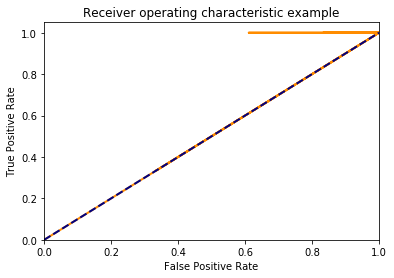

In [27]:
tpr = [r[0] for k, r in rates_dict.items()]
fpr = [r[1] for k, r in rates_dict.items()]

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()